# Защита персональных данных клиентов

Вам нужно защитить данные клиентов страховой компании «Хоть потоп». Разработайте такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обоснуйте корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import warnings

warnings.filterwarnings('ignore')

## Загрузка данных

In [2]:
data = pd.read_csv('/datasets/insurance.csv')
data.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


Данные загружены, пропусков нет.

In [4]:
data.describe()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


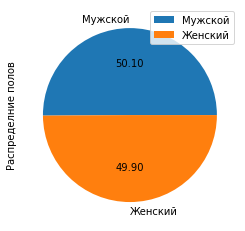

In [5]:
data.groupby(['Пол']).count().plot(kind='pie', y='Возраст', autopct='%.2f', labels=['Мужской', 'Женский'])
plt.ylabel('Распределние полов');

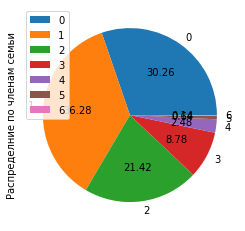

In [6]:
data.groupby(['Члены семьи']).count().plot(kind='pie', y='Возраст', autopct='%.2f')
plt.ylabel('Распределние по членам семьи');

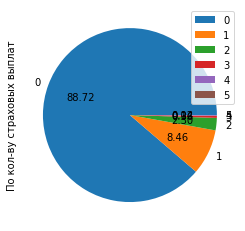

In [7]:
data.groupby(['Страховые выплаты']).count().plot(kind='pie', y='Возраст', autopct='%.2f')
plt.ylabel('По кол-ву страховых выплат');

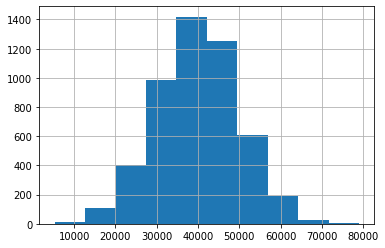

In [8]:
data['Зарплата'].hist();

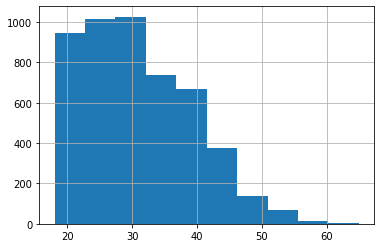

In [9]:
data['Возраст'].hist();

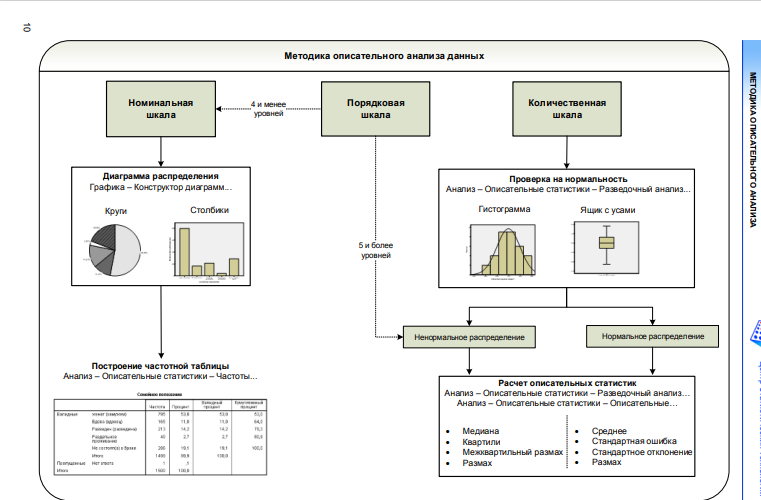

## Умножение матриц

В этом задании вы можете записывать формулы в *Jupyter Notebook.*

Чтобы записать формулу внутри текста, окружите её символами доллара \\$; если снаружи —  двойными символами \\$\\$. Эти формулы записываются на языке вёрстки *LaTeX.* 

Для примера мы записали формулы линейной регрессии. Можете их скопировать и отредактировать, чтобы решить задачу.

Работать в *LaTeX* необязательно.

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

 Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии?

**Ответ:** нет

**Обоснование:** Пусть $A$ - случайная обратимая матрица, тогда получим:  

$$
a_{1} = X_{1}w_{1}
$$

Где:  

$$
X_{1} = XA
$$

Тогда:

$$
w_{1} = (X_{1}^T X_{1})^{-1} X_{1}^T y
$$

$$
w_{1} = ((XA)^T(XA))^{-1}(XA)^T y
$$

$$
w_{1} = (A^TX^TXA)^{-1}A^TX^T y
$$

$$
w_{1} = (A^TX^TXA)^{-1}A^TX^T y
$$

$$
w_{1} = A^{-1}(X^TX)^{-1}(A^T)^{-1}A^TX^T y
$$

Т.к. $(A^T)^{-1}A^T = E$, получим:  

$$
w_{1} = A^{-1}(X^TX)^{-1}X^T y
$$

$(X^TX)^{-1}X^T y = w$, следовательно:

$$
w_{1} = A^{-1}w
$$

Посмотрим, что у нас получилось:  

$$
a_{1} = X_{1}w_{1}
$$

$$
a_{1} =  XAA^{-1}w
$$

$$
a_{1} = Xw
$$

Ч. и т. д.

## Алгоритм преобразования

**Алгоритм**

Будем умножать матрицу наших признаков на случайную обратимую матрицу.  Для ее проверки на обратимость будем проверять значение ее определителя(для обратимой матрице он должен быть не равен 0).

В методе fit() создаем обратимую матрицу, умножим матрицу признаков на случайную матрицу, добавим единичный столбец, создадим переменные w и w0. В методе predict() умножим тестовые признаки на случайную матрицу и вернем произведение, получившегося результата, на w, в сумме с w0. 

**Обоснование**

На основе предыдущего пункта, можем с уверенностью сказать, что умножение на случайную обратимую матрицу наших выборок, не изменит качества линейной регрессии.

## Проверка алгоритма

Для проверки создадим 2 алгоритма: с защитой данных и без.

In [10]:
class LinearRegression_def:
    def fit(self, train_features, train_target):
        length = len(train_features.columns)
        det = 0
        while(det == 0):
            self.A = np.random.normal(size=(length, length))
            det = np.linalg.det(self.A)
        X = train_features @ self.A
        X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
        y = train_target
        w = (np.linalg.inv(X.T.dot(X)).dot(X.T)).dot(y)
        self.w = w[1:]
        self.w0 = w[0]

    def predict(self, test_features):
        B = test_features @ self.A
        return B.dot(self.w) + self.w0

In [11]:
class LinearRegression:
    def fit(self, train_features, train_target):
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)
        y = train_target
        w = (np.linalg.inv(X.T.dot(X)).dot(X.T)).dot(y)
        self.w = w[1:]
        self.w0 = w[0]

    def predict(self, test_features):
        return test_features.dot(self.w) + self.w0

Проверим алгоритм. Но для начала подготовим данные. Разделим их на обучающие и тестовые выборки.

In [12]:
features = data.drop('Страховые выплаты', axis=1)
target = data['Страховые выплаты']

In [13]:
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                           test_size=0.25, random_state=12345)

In [14]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3750 entries, 3369 to 4578
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Пол          3750 non-null   int64  
 1   Возраст      3750 non-null   float64
 2   Зарплата     3750 non-null   float64
 3   Члены семьи  3750 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 146.5 KB


In [15]:
len(target_train)

3750

In [16]:
features_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1250 entries, 3183 to 1205
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Пол          1250 non-null   int64  
 1   Возраст      1250 non-null   float64
 2   Зарплата     1250 non-null   float64
 3   Члены семьи  1250 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 48.8 KB


In [17]:
len(target_test)

1250

Маштабируем признаки.

In [18]:
features_train

,Пол,Возраст,Зарплата,Члены семьи
3369,1,43.0,36200.0,1
1441,1,34.0,57600.0,0
571,0,32.0,41100.0,1
225,0,36.0,45100.0,1
2558,0,33.0,50600.0,2
...,...,...,...,...
3497,0,42.0,32100.0,0
3492,0,28.0,22700.0,4
2177,1,41.0,44700.0,1
3557,0,22.0,50100.0,4


In [19]:
numerical = ['Возраст', 'Зарплата', 'Члены семьи']
scaler = StandardScaler()
scaler.fit(features_train[numerical])
features_train[numerical] = scaler.transform(features_train[numerical])
features_test[numerical] = scaler.transform(features_test[numerical])

Обучим модели и проверим их на метрике R2

In [20]:
model = LinearRegression()
model.fit(features_train, target_train)
predcitions = model.predict(features_test)
print('R2 модели без защиты данных равен', r2_score(target_test, predcitions))

R2 модели без защиты данных равен 0.4352275712702667


In [21]:
model_def = LinearRegression_def()
model_def.fit(features_train, target_train)
predcitions_def = model_def.predict(features_test)
print('R2 модели с защитой данных равен', r2_score(target_test, predcitions_def))

R2 модели с защитой данных равен 0.4352275712702667


R2 моделей с защитой данных и без практически равны. Качество не изменилось, следовательно уместно осуществлять защиту данных с помощью случайной обратимой матрицы.